***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 2</span> 

# Helmholtz Machine on Well-formed Bound

This notebook examines the capacity of the vanilla Helmholtz machine and gives a light introduction to the mechanism of **active sampling**. Although it's not my original motivation of incorporating active sampling to a machine learning model, I guess this may be an easier way for people to understand the meaning and necessity of it and what kind of problem it could solve. I will shed light on more elaborated explanations later on but let's get started light-heartedly...

*Updated:* December 7, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Previously on...

It's been 8 months since we last updated on the Helmholtz series (oops..) lots of things happened, I guess I first deviated to the active inference conference, since I never atteded a conference before so I had to hurry up and wrap everything up in one week to manage the deadline. The results were unexpected, I not only made it to Ghent, but also made it to Paris with the same kind of work! Then I deviated a little bit to music generation, as that's a continuing endeavor of my career and I have to lead it to fruition somehow... I also did a lot of travelling in summer! China, Japan, France, Belgium, etc. But the contemplation on the Helmholtz machine never terminates, so let me recap what we were left half a year ago...

The idea is still on well-formed and preference sets, and the data is generated by the rules accordingly.

<img src="Venn_1.jpg" style="width:400px;height:350px;">
<caption><center> **Figure 1**: Venn Diagram for Ground Truth Data  </center></caption>

Let's continue with the first preliminary experiment (which was really done in a hurry, but thanks to it, I made it to IWAI conference!). In this experiment, we use the well-formed set as the pre-given dataset (ignoring the preference set here) and firstly use this dataset to test the performance of the Helmholtz machine. We agree on that a dataset should be some regularity over all possibilities of the given space, like in image generation there is always a difference between image and noise, which deliminates the given dataset from the rest of the possible generations (which is considered as noise, or false examples if not considering exposure bias). In our example, the well-formed set bounds the regularity of patterns, which means anything not included in the well-formed set is a false instance, thus should not be generated by the model. **Our goal is that, by training the model, we want to eliminate any possibility of generating false instances**. If you have biological inclined thoughts, you can make anology of the well-formed set to the survival status of a phenotype. Once this bound is transgressed, the phenotype's survival status is challenged, like extreme climates, low oxygen proportions, shortage of water, etc., thus the agent would die in these states. Therefore, any of such negative state could not be sampled by the model. If you have more machine learning type of logic, you can make analogy of this situation to the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) in classification problem:

<img src="FP.jpg" style="width:550px">
<caption><center> **Figure 2**: Confusion Matrix  </center></caption>

In our case, we assign infinite punishment on the false positive case, which means we give zero tolerence to the false alarms which cause the agent's life in danger; on the other hand, for the false negative case, we are quite generous since the agent doesn't need to know every corner of the world to live a life; it can choose its habitat and live comfortably within it as long as it wants to. This situation is visualized as the graph below:

<img src="set_show.jpg" style="width:550px">
<caption><center> **Figure 3**: Illustration of the Generative Set  </center></caption>

Unlike the classification problem, now we are assessing a generative model, thus the goal is to generate a distribution within the regularity bound (well-formed set) thus no FP occurs. Let's see how the Helmholtz machine performs.

$$
D_{KL}(Q || P) = E_Q [\log \frac{Q}{P}]
$$

KL-divergence is unsymmetric, which penalizes for false positive but not for false negative (Figure 3). 


#### Experiment 1: A test on the generative capacity of vanilla Helmholtz machine

The dataset we use is the well-formed set generated with the well-formedness rules:

1. Start with 1
2. Forbid 00100 (no 100, 001 on the boundary)
3. Forbid 0000

We use a 10-node pattern with binary values thus there are 1024 combinations of all patterns, of which the well-formed set contains 256 instances. The dataset is generated as below:

In [2]:
n = 10
well_formed_set = np.zeros([1,n])
well_formed_set[0,0] = 1

for i in range(1,n):
    for j in range(np.shape(well_formed_set)[0]):
        if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
            well_formed_set[j,i] = 1
        else:
            well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
            well_formed_set[j,i] = 1
            
ind = np.array([], dtype=np.int8)
for i in range(well_formed_set.shape[0]):
    if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
        ind = np.append(ind,i)

well_formed_set = np.delete(well_formed_set,ind,0)
well_formed_set = (well_formed_set - 0.5)*2
well_formed_set = np.transpose(well_formed_set)
well_formed_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [3]:
well_formed_set.shape

(10, 256)

The Helmholtz machine structure is given as below:

<img src="Helmz.jpg" style="width:550px">
<caption><center> **Figure 4**: The Helmholtz Machine  </center></caption>

I previously wrote in Document 2 about the variational objective function and deduction of the parameter updating rules of the Helmholtz machine, and I will give a more systematic analysis on these matters in upcoming notebooks, so here let's skip these steps and say we know the parameter updating local delta rule is as follows:

$$
\frac{\partial \tilde{F}}{\partial \phi_{k,n}^{m-1,m}} = \left \{
\begin{array}{ll}
-s_k^{m-1}(1-q_n^m) & \text{if } s_n^m = 1 \\
s_k^{m-1} \centerdot q_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$

$$
\frac{\partial F}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = 1 \\
s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$

Let's write the functions to run this model...

We always have the bottom layer as data input, denoted as $d_0$. In our case illustrated in Figure 4, we have $m = 4$ layers, with various numbers of neurons, $n_{d_0} = 10$, $n_{z_1} = 8$, $n_{z_2} = 5$, $n_{z_3} = 3$. These are the hyperparameters to initialize the model.

In [36]:
def parameter_initialization(init_type,n_dz):
    """
    Arguments:
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
    n_dz -- number of neurons for each layer, numpy array of shape (m, ), where m is the number of layers
    
    Returns:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    """
    Phi = {}
    Theta = {}
    m = len(n_dz)
    if init_type == "zero":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((n_dz[i+1],n_dz[i]+1))
            Theta["Theta_" + str(i+1) + str(i)] = np.zeros((n_dz[i],n_dz[i+1]+1))
        Theta["Theta_k"] = np.zeros((n_dz[-1],1))
    elif init_type == "random":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(n_dz[i+1],n_dz[i]+1)
            Theta["Theta_" + str(i+1) + str(i)] = np.random.randn(n_dz[i],n_dz[i+1]+1)
        Theta["Theta_k"] = np.random.randn(n_dz[-1],1)
    else:
        raise Exception("Wrong Init Type")
    return Phi, Theta

In [37]:
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization(init_type,n_dz)

In [43]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [70]:
def wake_forward(d0,Phi):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    
    Returns:
    Q -- probability of each neuron (taking value 1), Python dictionary of same length as Phi with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Q = {}
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
        S = ((q > np.random.rand(len(q),1)).astype(int) - 0.5)*2    # rejection sampling
        Q["q"+str(i+1)] = q
        Alpha_Q["z"+str(i+1)] = S
    return Q, Alpha_Q

In [71]:
d0 = well_formed_set[:,5:6]

In [72]:
Q, Alpha_Q = wake_forward(d0,Phi)

In [50]:
def sleep_forward(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    P -- probability of each neuron (taking value 1), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    
    m = len(Theta)
    P = {"p"+str(m-1):p}
    Alpha_P = {"z"+str(m-1):S}
    
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
        P["p"+str(i-1)] = p
        Alpha_P["z"+str(i-1)] = S
    return P, Alpha_P

In [51]:
P, Alpha_P = sleep_forward(Theta)

In [103]:
def wake_update_delta(Phi,Alpha_P,lr):
    
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- Generative assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    info_gain_wake -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_Q -- cumsum of all terms in info_gain_wake, a measurement of discrepancy between the generative assignment and 
    the recognition model
    """
    n = len(Phi)
    info_gain_wake = {}
    error_Q = 0
    for i in range(n):
        S_bias = np.append(Alpha_P["z"+str(i)],[[1]], axis=0)
        q = sigmoid(np.matmul(Phi["Phi_" + str(i) + str(i+1)],S_bias))
        gain = q - (1+Alpha_P["z"+str(i+1)])/2
        Phi["Phi_" + str(i) + str(i+1)] -= lr * np.outer(gain,S_bias)
        info_gain_wake["z"+str(i+1)] = gain # positive(s=-1) & negative(s=1)
        error_Q += (np.abs(gain)).sum()
    
    return Phi, info_gain_wake,error_Q

In [104]:
lr = 0.01

In [105]:
Phi, info_gain_wake,error_Q = wake_update_delta(Phi,Alpha_P,lr)

From the information gain, we can read the error of the given assignment *Alpha_P* for parameters *Phi*, on each neuron it computes. The value of info_gain is within $[-1,1]$, where positive value indicates the current neuron takes value $-1$, while negative value indicates that the current neuron takes value $1$. 

In [124]:
def sleep_update_delta(Theta,Alpha_Q,lr):
    
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    info_gain_sleep -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_P -- cumsum of all terms in info_gain_sleep, a measurement of discrepancy between the recognition assignment and 
    the generative model
    """
    n = len(Theta)
    info_gain_sleep = {}
    error_P = 0
    
    p = sigmoid(Theta["Theta_k"])
    gain = p - (1+Alpha_Q["z"+str(n-1)])/2
    Theta["Theta_k"] -= lr * gain
    info_gain_sleep["z"+str(n-1)] = gain
    error_P += (np.abs(gain)).sum()
    
    for i in range(n-1,0,-1):
        S_bias = np.append(Alpha_Q["z"+str(i)],[[1]], axis=0)
        p = sigmoid(np.matmul(Theta["Theta_" + str(i) + str(i-1)],S_bias))
        gain = p - (1+Alpha_Q["z"+str(i-1)])/2
        Theta["Theta_" + str(i) + str(i-1)] -= lr * np.outer(gain,S_bias)
        info_gain_sleep["z"+str(i-1)] = gain # positive(s=-1) & negative(s=1)
        error_P += (np.abs(gain)).sum()
    
    return Theta, info_gain_sleep, error_P

In [108]:
Theta, info_gain_sleep, error_P = sleep_update_delta(Theta,Alpha_Q,lr)

Let's train the model...

In [126]:
# dataset
well_formed_set.shape

(10, 256)

In [131]:
# parameters
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization(init_type,n_dz)

Like stochastic gradient descent, we update the parameters for each data input (no batch).

In [298]:
n_q = n_dz[1:].sum()
n_p = n_dz.sum()
lr = 0.05
epoch = 300
n_data = well_formed_set.shape[1]

for e in range(epoch):
    error_P_all = 0
    error_Q_all = 0
    for i in range(n_data):
        d0 = well_formed_set[:,i:i+1]
        Q, Alpha_Q = wake_forward(d0,Phi)
        Theta, info_gain_sleep, error_P = sleep_update_delta(Theta,Alpha_Q,lr)
        error_P_all += error_P/n_p

        P, Alpha_P = sleep_forward(Theta)
        Phi, info_gain_wake,error_Q = wake_update_delta(Phi,Alpha_P,lr)
        error_Q_all += error_Q/n_q

    error_P_all = error_P_all/n_data
    error_Q_all = error_Q_all/n_data
    print(error_P_all,error_Q_all)

0.15901168833946058 0.03421493060559103
0.15983237228741018 0.042337448041664415
0.16089064198945544 0.037757960873685444
0.1602820853040595 0.043463366422903986
0.162436147332215 0.045190349067424675
0.16257998694032066 0.04658391600957921
0.16106838165648743 0.04114501347645634
0.15999348229902471 0.04330094169931256
0.1584051683663183 0.04294083195459657
0.16345340897528995 0.0469827252502302
0.15954049624880587 0.04614623403714955
0.15901594227101018 0.043286068320060475
0.1614373295494023 0.0482873288450563
0.16343093765649377 0.04968456863149329
0.16324437340257036 0.047771559750944236
0.16257391740114227 0.04028638985493899
0.16285101059290302 0.048896744479330075
0.16046760106335872 0.047016229855362385
0.1617716259513267 0.04500475671167798
0.16267413311220677 0.046086984290861464
0.16525616759754688 0.04369494757312913
0.16414483433822427 0.043707828461685826
0.16447360555760385 0.052850497618348515
0.16368339302449905 0.05146749276637143
0.16510679902349978 0.048162186766889

0.15245652588906716 0.03198774311547361
0.15286715996775388 0.03326996890171346
0.15412192116190543 0.029019132488549183
0.15419642957633004 0.035434682344561985
0.15433995495862807 0.03709293628468684
0.15574835034118648 0.03303354965457896
0.15505326982168643 0.03551112862059931
0.15937608099891723 0.03528630689334713
0.15716076756459138 0.03377466531832348
0.1568022193613375 0.031138509556607505
0.15322360011465833 0.032304248000965693
0.15700719299597318 0.035276899818700184
0.1577819749968263 0.03755814813086247
0.15801757475467115 0.039539101646228966
0.1608077651621636 0.0418057565195051
0.15899719295864057 0.04812908981959807
0.15972925338345884 0.04630273973598578
0.15976349100337156 0.042706536129753565
0.1601695969240812 0.04506974981368085
0.15791579507694029 0.042467408628736394
0.15893789816076473 0.04299895972559209
0.1627490313455255 0.04587128563040534
0.16133112345924458 0.045591503409809116
0.15971269110689995 0.038719820864645114
0.159417567900173 0.0408797872196130

Let's generate with this model...

In [246]:
def generate(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    S -- generation of one instance, numpy array of shape (n_d, )
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    m = len(Theta)
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
    return S

We want to examine the distribution of generation. We let the model generate, say 10000 instances, then use the samples to approximate its generative distribution.

In [299]:
n_sample = 10000
generation = np.zeros((n_dz[0],n_sample))
for i in range(n_sample):
    generation[:,i:i+1] = generate(Theta)

We know there are 1024 combinations in total, which gives 1024 categories. Here we use integer numbers 0-1023 to represent these combinations and for visualization, we assign 0-255 as our well-formed set.

In [172]:
n = 10
entire_set = np.zeros((2,10))
entire_set[0,0] = 1
for i in range(1,n):
    for j in range(entire_set.shape[0]):
        entire_set = np.append(entire_set, entire_set[j:j+1,:], axis=0)
        entire_set[j,i] = 1
entire_set = (entire_set - 0.5)*2
entire_set = np.transpose(entire_set)
entire_set

array([[ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1., -1., ...,  1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [197]:
entire_set = np.unique(entire_set, axis=1)
well_formed_set = np.unique(well_formed_set, axis=1)
reordered_set = np.zeros(entire_set.shape)
reordered_set[:,:well_formed_set.shape[1]] = well_formed_set

k = well_formed_set.shape[1]
for i in range(entire_set.shape[1]):
    flag = 0
    for j in range(well_formed_set.shape[1]):
        if np.array_equal(entire_set[:,i], well_formed_set[:,j]):
            flag = 1
            break
    if flag == 0:
        reordered_set[:,k] = entire_set[:,i]
        k += 1
reordered_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1.,  1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.]])

In reordered_set, we set the first 256 columns as the well-formed set and the rest as negative samples outside of well-formed bound. Now we calculate the distribution of generation.

In [300]:
distribution = np.zeros((generation.shape[1], ),dtype = int)
for i in range(generation.shape[1]):
    for j in range(reordered_set.shape[1]):
        if np.array_equal(generation[:,i], reordered_set[:,j]):
            distribution[i] = j
            break

In [301]:
distribution

array([243, 237, 247, ..., 211, 244, 253])

In [302]:
values, counts = np.unique(distribution, return_counts=True)
counts.size

252

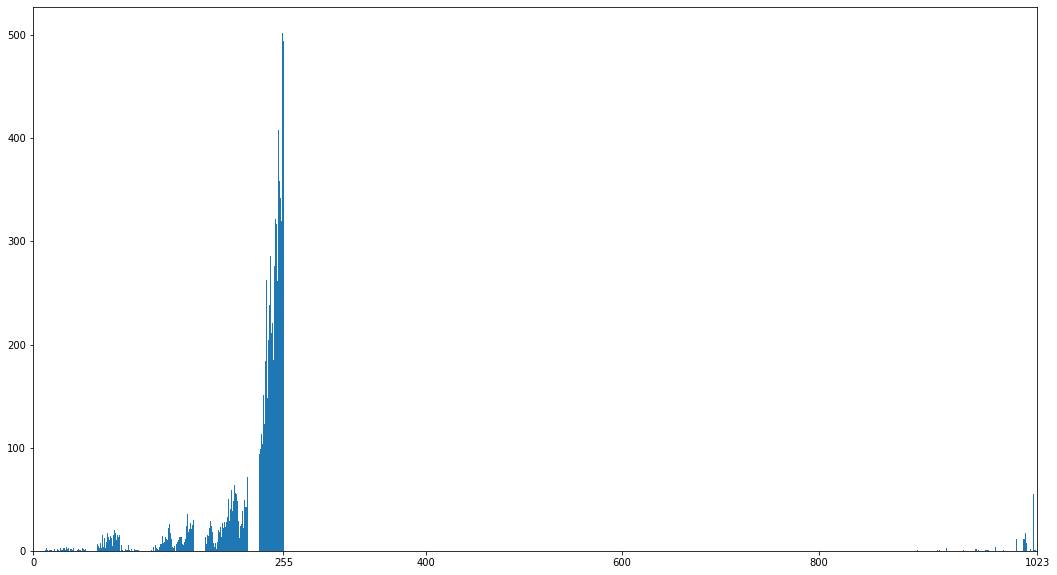

In [303]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values,counts)
ax.set(xlim=(0, 1023), xticks=np.array([0,255,400,600,800,1023]))
plt.show()

In [304]:
# Percentage of correct instances among all generations
counts[values < 256].sum()/generation.shape[1]

0.9836

In [305]:
statistics = np.zeros((2,counts.size),dtype=int)
statistics[0,:] = values
statistics[1,:] = counts
statistics

array([[   1,    6,   13,   14,   15,   17,   18,   19,   22,   25,   26,
          28,   29,   30,   31,   32,   33,   34,   35,   36,   38,   39,
          40,   41,   45,   46,   47,   48,   50,   51,   52,   53,   54,
          55,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
          67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
          78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          90,   91,   94,   95,   96,   97,   98,  100,  103,  104,  105,
         106,  107,  109,  110,  112,  113,  114,  115,  116,  117,  118,
         119,  120,  121,  123,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
         143,  144,  146,  147,  148,  149,  150,  151,  152,  153,  154,
         155,  156,  157,  158,  159,  160,  161,  162,  163,  164,  165,
         166,  167,  168,  169,  170,  171,  172,  173,  174,  175,  176,
         177,  178,  179,  180,  181, 

In [287]:
counts[values > 69]

array([ 16,  14,  10,  12,  16,  17,  21,  14,  18,  32,  28,  23,  19,
        19,  18,  19,  17,  36,   8,   1,   6,   3,   1,   1,   1,   1,
         1,   4,   1,   1,   3,  12,   6,   2,   5,   3,   2,   5,   7,
         8,   8,   4,   3,   1,   5,   5,   5,   2,   6,   2,   7,   5,
         3,   8,  13,   4,  10,   5,   4,   9,  13,  22,  13,   4,   2,
        10,   9,   4,  16,   7,   5,  10,  22,  22,   7,  17,  14,  23,
        23,  36,  18,  24,  15,  19,  14,  32,  26,  31,  18,   3,   6,
         2,  10,   6,   4,  11,  16,  11,  13,  14,  13,  14,  22,  32,
        14,  12,   8,  17,  26,  13,  34,  27,  20,  24,  36,  46,  30,
        27,  25,  33,  49,  88,  48,  58,  47,  54,  40,  64,  70,  71,
        41,  18,  23,  48,  28,  42,  77,  68,  74,  87,  60,  55,  55,
       125, 101,  91,  97, 120, 121, 135, 132, 176, 118,  68, 104, 115,
        73, 206, 140, 123, 198, 251, 142, 245, 329, 187, 212, 137, 293,
       310, 380, 198, 318, 250, 260, 195, 442, 236,   1,   2,   

In [309]:
reordered_set[:,1019]

array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.])

In [310]:
Theta

{'Theta_10': array([[ 0.03542588, -0.40604692,  0.3781762 , -0.49153731, -0.08397746,
         -0.2010533 ,  0.33549308,  0.07632863,  9.5571646 ],
        [ 0.01119892,  0.08971083, -0.27453663, -3.37715804, -7.07492649,
         -0.33290296, -0.24189164, -0.43415471, -2.5426537 ],
        [ 0.59657965,  0.02172891,  1.09085874,  1.87806213,  2.99995893,
          1.42338677, -0.25050324,  0.97784309,  6.23538604],
        [ 0.02987976,  0.02188166, -1.03303348,  0.0451028 , -0.07219841,
         -0.70036023, -0.16251728, -1.88482923,  3.95338621],
        [ 0.04544263, -0.45661886, -1.00715182,  0.72660779, -0.04020447,
         -1.10307841, -0.43866377,  4.04857463, -1.87613424],
        [ 0.44621878,  0.13255316, -0.15442986,  1.17574402, -0.44753401,
         -0.75127768,  4.35156392,  0.22097469,  0.84495479],
        [ 0.2386661 , -2.66350125,  0.15657567, -0.76012247,  0.06498884,
         -2.37754893, -0.1609274 , -0.01633704, -0.35521378],
        [-0.04039548,  4.80963361,  